In [1]:
import numpy as np
import PIL.Image

img = PIL.Image.open("example_screens/chesscom_screen.png")
print(f"Loaded image ({img.size[0]}px x {img.size[1]}px)")

# Resize if image larger than 2k pixels on a side
if img.size[0] > 2000 or img.size[1] > 2000:
    print(f"Image too big ({img.size[0]} x {img.size[1]})")
    new_size = 800.0
    if img.size[0] > img.size[1]:
        # resize by width to new limit
        ratio = new_size / img.size[0]
    else:
        # resize by height
        ratio = new_size / img.size[1]
    print("Reducing by factor of %.2g" % (1./ratio))
    nx , ny = int(img.size[0] * ratio) , int(img.size[1] * ratio)
    
    img = img.resize((nx,ny), PIL.Image.ADAPTIVE)
    print(f"New size: ({img.size[0]}px x {img.size[1]}px)")

Loaded image (2880px x 1800px)
Image too big (2880 x 1800)
Reducing by factor of 3.6
New size: (800px x 500px)


In [2]:
from io import StringIO
from IPython.display import clear_output, Image, display

def display_array(a, rng=[0,1]):
    a = (a - rng[0])/float(rng[1] - rng[0])*255
    a = np.uint8(np.clip(a, 0, 255))
    display(PIL.Image.fromarray(a))

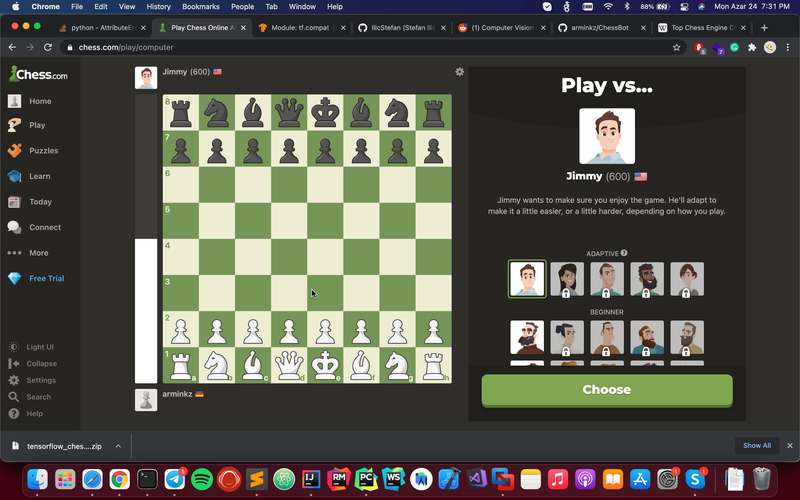

In [3]:
display_array(np.asarray(img),rng=[0,255])

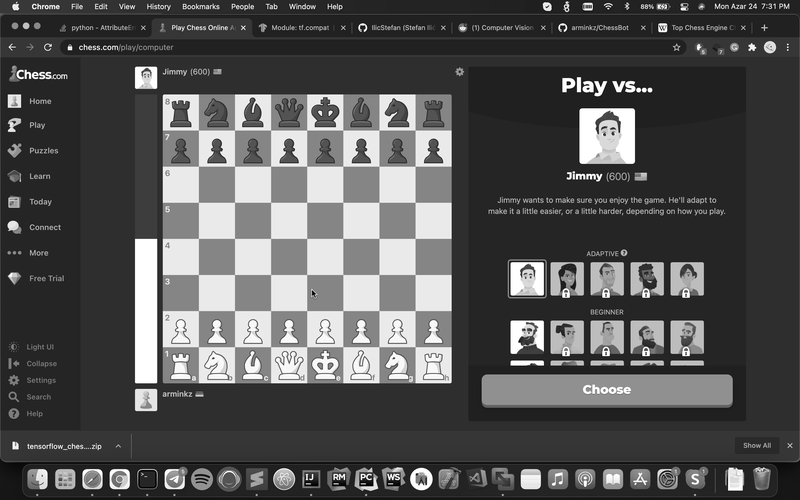

In [4]:
# Convert to grayscale and array
grey = np.asarray(img.convert('L'), dtype=np.float32)
display_array(grey,rng=[0,255])

In [5]:
import tensorflow as tf

# we need to perform some 2d-convs using tensorflow

# convert kernel matrix to tensor-compatible filter
def make_tf_kernel(k):
    k = np.asarray(k)
    # reshape it to tensorflow 4-D filter
    k = k.reshape(list(k.shape) + [1,1])
    return tf.constant(k, dtype=tf.float32)


# Simple 2D convolution
def simple_conv2d(x,k):
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    return y[0, :, :, 0]


def gradient_x(x):
    k = make_tf_kernel([[-1,0,1],
                        [-1,0,1],
                        [-1,0,1]])
    return simple_conv2d(x,k)


def gradient_y(x):
    k = make_tf_kernel([[-1,-1,-1],
                        [0,0,0],
                        [1,1,1]])
    return simple_conv2d(x,k)

In [6]:
dX = gradient_x(grey)
dY = gradient_y(grey)

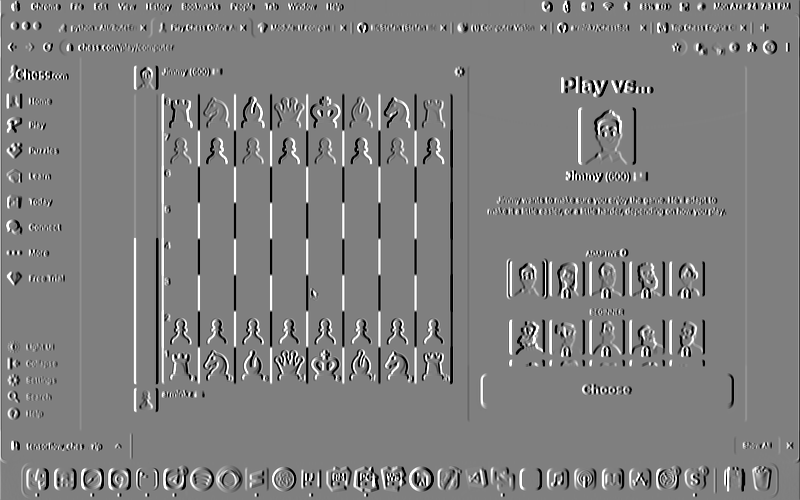

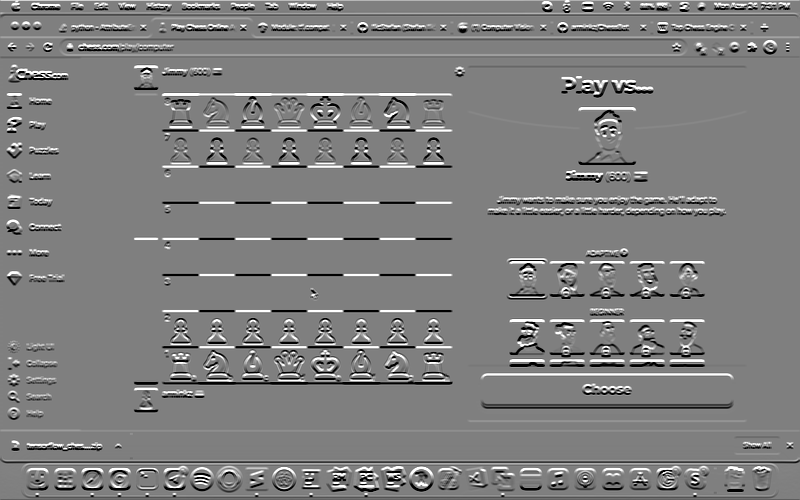

In [7]:
display_array(dX, rng=[-255,255])
display_array(dY, rng=[-255,255])

In [8]:
dX_pos = tf.clip_by_value(dX, 0., 255., name="dx_positive")
dX_neg = tf.clip_by_value(dX, -255., 0., name="dx_negative")
dY_pos = tf.clip_by_value(dY, 0., 255., name="dy_positive")
dY_neg = tf.clip_by_value(dY, -255., 0., name="dy_negative")


dX_hough = tf.reduce_sum(dX_pos, 0) * tf.reduce_sum(-dX_neg, 0) / (grey.shape[0]*grey.shape[0])
dY_hough = tf.reduce_sum(dY_pos, 1) * tf.reduce_sum(-dY_neg, 1) / (grey.shape[1]*grey.shape[1])

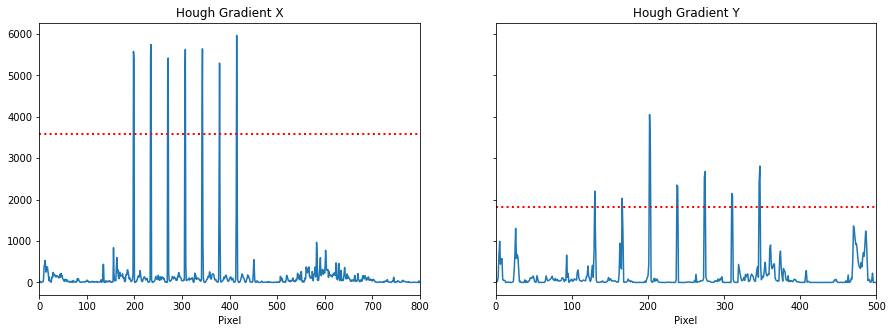

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(15,5))

# Arbitrarily choose half of max value as threshold, since they're such strong responses
dX_hough_thresh = tf.reduce_max(dX_hough) * 0.6
dY_hough_thresh = tf.reduce_max(dY_hough) * 0.45

ax1.plot(dX_hough);
ax1.axhline(dX_hough_thresh, lw=2,linestyle=':',color='r')
ax1.set_title('Hough Gradient X')
ax1.set_xlabel('Pixel')
ax1.set_xlim(0,grey.shape[1])

ax2.plot(dY_hough)
ax2.axhline(dY_hough_thresh, lw=2,linestyle=':',color='r')
ax2.set_title('Hough Gradient Y')
ax2.set_xlim(0,grey.shape[0])
ax2.set_xlabel('Pixel');

In [10]:
import scipy.signal

# checks whether there exists 7 lines of consistent increasing order in set of lines
def checkMatch(lineset):
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    for line in linediff:
        # Within 5 px of the other (allowing for minor image errors)
        if np.abs(line - x) < 5:
            cnt += 1
        else:
            cnt = 0
            x = line
    return cnt == 5


# prunes a set of lines to 7 in consistent increasing order (chessboard)
def pruneLines(lineset):
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    start_pos = 0
    for i, line in enumerate(linediff):
        # Within 5 px of the other (allowing for minor image errors)
        if np.abs(line - x) < 5:
            cnt += 1
            if cnt == 5:
                end_pos = i+2
                return lineset[start_pos:end_pos]
        else:
            cnt = 0
            x = line
            print(i, x)
            start_pos = i
    return lineset


# return skeletonized 1d array (thin to single value, favor to the right)
def skeletonize_1d(arr):
    _arr = arr.copy() # create a copy of array to modify without destroying original
    # Go forwards
    for i in range(_arr.size-1):
        # Will right-shift if they are the same
        if arr[i] <= _arr[i+1]:
            _arr[i] = 0
    
    # Go reverse
    for i in np.arange(_arr.size-1, 0,-1):
        if _arr[i-1] > _arr[i]:
            _arr[i] = 0
    return _arr


# returns pixel indices for the 7 internal chess lines in x and y axes
def getChessLines(hdx, hdy, hdx_thresh, hdy_thresh):
    
    # Blur
    gausswin = scipy.signal.gaussian(21,4)
    gausswin /= np.sum(gausswin)

    # Blur where there is a strong horizontal or vertical line (binarize)
    blur_x = np.convolve(hdx > hdx_thresh, gausswin, mode='same')
    blur_y = np.convolve(hdy > hdy_thresh, gausswin, mode='same')


    skel_x = skeletonize_1d(blur_x)
    skel_y = skeletonize_1d(blur_y)

    # Find points on skeletonized arrays (where returns 1-length tuple)
    lines_x = np.where(skel_x)[0] # vertical lines
    lines_y = np.where(skel_y)[0] # horizontal lines
    
    # Prune inconsistent lines
    lines_x = pruneLines(lines_x)
    lines_y = pruneLines(lines_y)
    
    is_match = len(lines_x) == 7 and len(lines_y) == 7 and checkMatch(lines_x) and checkMatch(lines_y)
    
    return lines_x, lines_y, is_match

# Get chess lines
lines_x, lines_y, is_match = getChessLines(tf.keras.backend.flatten(dX_hough), \
                                           tf.keras.backend.flatten(dY_hough), \
                                           dX_hough_thresh, \
                                           dY_hough_thresh)

lines_x, lines_y, is_match = getChessLines(tf.keras.backend.flatten(dX_hough), \
                                           tf.keras.backend.flatten(dY_hough), \
                                           dX_hough_thresh*.9, \
                                           dY_hough_thresh*.9)

print("X",lines_x, np.diff(lines_x))
print("Y",lines_y, np.diff(lines_y))
if is_match:
    print("Chessboard found")
else:
    print("Couldn't find Chessboard")


0 36
0 36
0 36
0 36
X [199 235 271 307 343 379 415] [36 36 36 36 36 36]
Y [130 166 203 239 275 311 347] [36 37 36 36 36 36]
Chessboard found


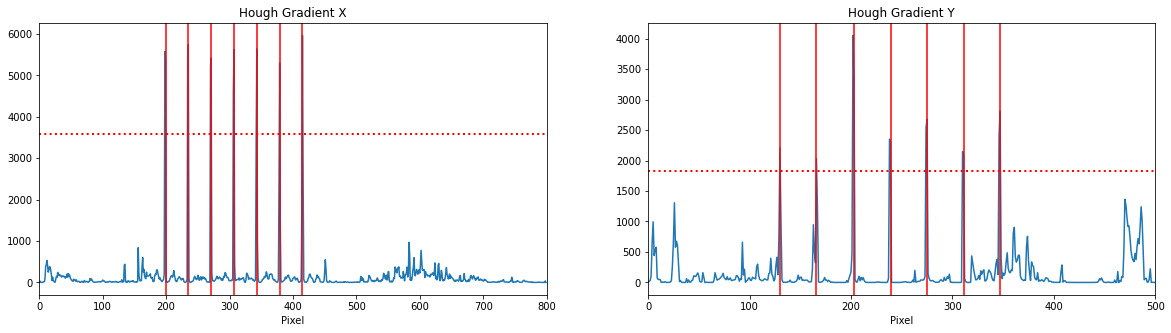

In [11]:
# Plot blurred 1d hough arrays and skeletonized versions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

ax1.plot(dX_hough);
ax1.axhline(dX_hough_thresh, lw=2,linestyle=':',color='r')
ax1.set_title('Hough Gradient X')
ax1.set_xlabel('Pixel')
ax1.set_xlim(0,grey.shape[1])

ax2.plot(dY_hough)
ax2.axhline(dY_hough_thresh, lw=2,linestyle=':',color='r')
ax2.set_title('Hough Gradient Y')
ax2.set_xlim(0,grey.shape[0])
ax2.set_xlabel('Pixel');

# Plot lines for where peaks where found
if len(lines_x < 20):
    for hx in lines_x:
        ax1.axvline(hx,color='r')
if len(lines_y < 20):
    for hy in lines_y:
        ax2.axvline(hy,color='r')

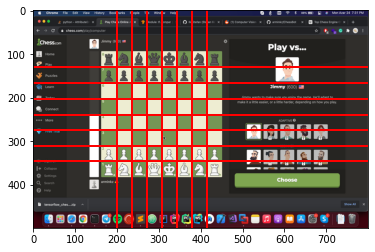

In [12]:
plt.imshow(img, aspect='auto')
for hx in lines_x:
    plt.axvline(hx, color='r', lw=2)

for hy in lines_y:
    plt.axhline(hy, color='r', lw=2)

In [13]:
print("X (vertical)",lines_x, np.diff(lines_x))
print("Y (horizontal)",lines_y, np.diff(lines_y))


# Split up input grayscale array into 64 tiles stacked in a 3D matrix using the chess linesets
def getChessTiles(a, lines_x, lines_y):
    # Find average square size, round to a whole pixel for determining edge pieces sizes
    stepx = np.int32(np.round(np.mean(np.diff(lines_x))))
    stepy = np.int32(np.round(np.mean(np.diff(lines_y))))
    
    # Pad edges as needed to fill out chessboard (for images that are partially over-cropped)
#     print stepx, stepy
#     print "x",lines_x[0] - stepx, "->", lines_x[-1] + stepx, a.shape[1]
#     print "y", lines_y[0] - stepy, "->", lines_y[-1] + stepy, a.shape[0]
    padr_x = 0
    padl_x = 0
    padr_y = 0
    padl_y = 0
    
    if lines_x[0] - stepx < 0:
        padl_x = np.abs(lines_x[0] - stepx)
    if lines_x[-1] + stepx > a.shape[1]-1:
        padr_x = np.abs(lines_x[-1] + stepx - a.shape[1])
    if lines_y[0] - stepy < 0:
        padl_y = np.abs(lines_y[0] - stepy)
    if lines_y[-1] + stepx > a.shape[0]-1:
        padr_y = np.abs(lines_y[-1] + stepy - a.shape[0])
    
    # New padded array
#     print "Padded image to", ((padl_y,padr_y),(padl_x,padr_x))
    a2 = np.pad(a, ((padl_y,padr_y),(padl_x,padr_x)), mode='edge')
    
    setsx = np.hstack([lines_x[0]-stepx, lines_x, lines_x[-1]+stepx]) + padl_x
    setsy = np.hstack([lines_y[0]-stepy, lines_y, lines_y[-1]+stepy]) + padl_y
    
    a2 = a2[setsy[0]:setsy[-1], setsx[0]:setsx[-1]]
    setsx -= setsx[0]
    setsy -= setsy[0]
#     display_array(a2, rng=[0,255])    
#     print "X:",setsx
#     print "Y:",setsy
    
    # Matrix to hold images of individual squares (in grayscale)
#     print "Square size: [%g, %g]" % (stepy, stepx)
    squares = np.zeros([np.round(stepy), np.round(stepx), 64],dtype=np.uint8)
    
    # For each row
    for i in range(0,8):
        # For each column
        for j in range(0,8):
            # Vertical lines
            x1 = setsx[i]
            x2 = setsx[i+1]
            padr_x = 0
            padl_x = 0
            padr_y = 0
            padl_y = 0

            if (x2-x1) > stepx:
                if i == 7:
                    x1 = x2 - stepx
                else:
                    x2 = x1 + stepx
            elif (x2-x1) < stepx:
                if i == 7:
                    # right side, pad right
                    padr_x = stepx-(x2-x1)
                else:
                    # left side, pad left
                    padl_x = stepx-(x2-x1)
            # Horizontal lines
            y1 = setsy[j]
            y2 = setsy[j+1]

            if (y2-y1) > stepy:
                if j == 7:
                    y1 = y2 - stepy
                else:
                    y2 = y1 + stepy
            elif (y2-y1) < stepy:
                if j == 7:
                    # right side, pad right
                    padr_y = stepy-(y2-y1)
                else:
                    # left side, pad left
                    padl_y = stepy-(y2-y1)
            # slicing a, rows sliced with horizontal lines, cols by vertical lines so reversed
            # Also, change order so its A1,B1...H8 for a white-aligned board
            # Apply padding as defined previously to fit minor pixel offsets
            squares[:,:,(7-j)*8+i] = np.pad(a2[y1:y2, x1:x2],((padl_y,padr_y),(padl_x,padr_x)), mode='edge')
    return squares

if is_match:
    # Possibly check np.std(np.diff(lines_x)) for variance etc. as well/instead
    print("7 horizontal and vertical lines found, slicing up squares")
    squares = getChessTiles(grey, lines_x, lines_y)
    print("Tiles generated: (%dx%d)*%d" % (squares.shape[0], squares.shape[1], squares.shape[2]))
else:
    print("Number of lines not equal to 7")

X (vertical) [199 235 271 307 343 379 415] [36 36 36 36 36 36]
Y (horizontal) [130 166 203 239 275 311 347] [36 37 36 36 36 36]
7 horizontal and vertical lines found, slicing up squares
Tiles generated: (36x36)*64


Order is row-wise from top left of image going right and down, so a8,b8....a7,b7,c7...h1
#0: A1.0


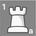

#1: B1.125


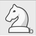

#2: C1.25


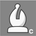

#3: D1.375


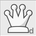

#4: E1.5


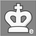

#5: F1.625


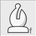

#6: G1.75


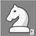

#7: H1.875


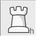

#8: A2.0


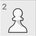

#9: B2.125


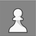

#10: C2.25


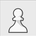

#11: D2.375


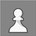

#12: E2.5


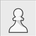

#13: F2.625


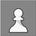

#14: G2.75


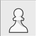

#15: H2.875


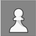

#16: A3.0


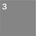

#17: B3.125


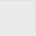

#18: C3.25


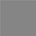

#19: D3.375


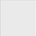

#20: E3.5


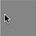

#21: F3.625


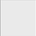

#22: G3.75


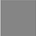

#23: H3.875


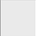

#24: A4.0


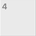

#25: B4.125


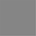

#26: C4.25


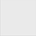

#27: D4.375


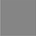

#28: E4.5


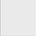

#29: F4.625


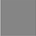

#30: G4.75


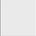

#31: H4.875


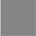

#32: A5.0


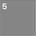

#33: B5.125


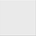

#34: C5.25


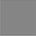

#35: D5.375


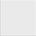

#36: E5.5


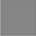

#37: F5.625


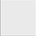

#38: G5.75


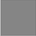

#39: H5.875


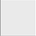

#40: A6.0


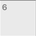

#41: B6.125


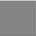

#42: C6.25


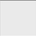

#43: D6.375


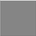

#44: E6.5


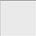

#45: F6.625


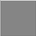

#46: G6.75


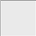

#47: H6.875


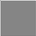

#48: A7.0


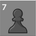

#49: B7.125


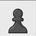

#50: C7.25


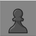

#51: D7.375


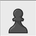

#52: E7.5


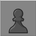

#53: F7.625


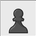

#54: G7.75


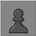

#55: H7.875


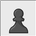

#56: A8.0


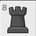

#57: B8.125


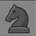

#58: C8.25


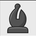

#59: D8.375


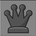

#60: E8.5


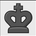

#61: F8.625


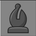

#62: G8.75


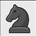

#63: H8.875


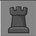

In [14]:
letters = 'ABCDEFGH'

if is_match:
    print("Order is row-wise from top left of image going right and down, so a8,b8....a7,b7,c7...h1")
    for i in range(64):
        print(f"#{i}: {letters[i%8]}{i/8+1}")
        display_array(squares[:,:,i],rng=[0,255])
else:
    print("Didn't have lines to slice image up.")